# Reduced Order Models (ROM)

**Students:**

Guilherme Marim - RA: 232092

## Objective

Get a **Reduce Order Model** to solve the Buckley-Leverett equation with the analytical solution (for the Non-convex flux without diffusion term) using a Neural Network (NN).

Buckley-Leverett equation: 

\begin{equation}
    u_{t} + \left ( f_{w} \right )_x = 0
\end{equation}

where $f_{w} = f_{w}(u)$

Initial and boundary conditions:

\begin{equation}
    u(x,t) = 0, \forall x \ and \ t = 0,
\end{equation}

\begin{equation}
    u(x,t) = 1, x = 0 \ and \ t > 0.
\end{equation}

Analytical solution non-convex flux:


\begin{equation}
    f_w(u) = \frac{u^{2}}{u^{2} + \frac{(1-u)^2}{M}},
\end{equation}

where $$M = 1$$

For this analytical solution (Non-convex flux) without diffusion term the residual term contains a shock and a rarefaction wave and is constructed as follows:

\begin{equation}
    u(x,t) = \left \{ \begin{matrix}
    0 & \frac{x}{t} > {f}'_w(u^*) \\ 
    u(\frac{x}{t})& {f}'_w(u^*) \geq \frac{x}{t} \geq {f}'_w(u=1)\\ 
    1 & {f}'_w(u=1) \geq \frac{x}{t}
    \end{matrix} \right.
\end{equation}

where $u^*$ denotes the shock location.


## Loading Dataset

**Loading Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Loading Dataset Buckley-Leverett**

In [2]:
X = np.load('BL_X.npy')
T = np.load('BL_T.npy')
U = np.load('BL_U.npy')

In [3]:
def plot_data_time_serie(x_grid, u_final):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_grid, u_final[25])
    plt.title('t = 0.25')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 2)
    plt.plot(x_grid, u_final[50])
    plt.title('t = 0.5')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 3)
    plt.plot(x_grid, u_final[75])
    plt.title('t = 0.75')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

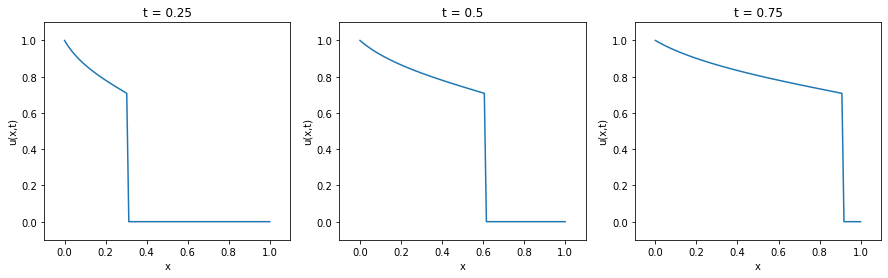

In [4]:
plot_data_time_serie(X[0,:], U)

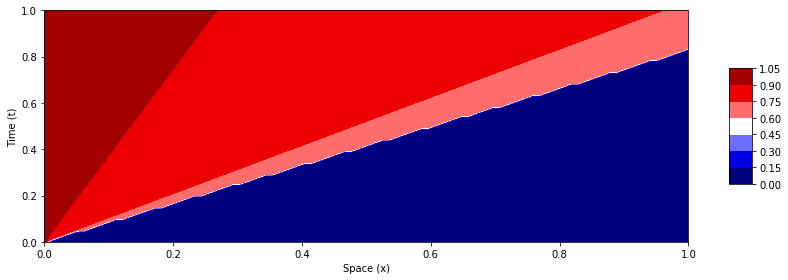

In [5]:
def plot_data(X, T, U, title=''):
    fig, ax = plt.subplots(figsize=(12, 4))

    surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.xlabel('Space (x)')
    plt.ylabel('Time (t)')
    plt.tight_layout()

plot_data(X, T, U)

In [6]:
U.shape

(100, 100)

In [7]:
def plot_data_compare(X, T, U, U_reduced, k, variance, title_1='Original data', title_2='Reduced data', title_3='Absolute difference'):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 7))
    plt.suptitle(f'Training set reconstruction with {k} components ({round(variance, 2)}% variance)', y=1.02)

    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title(title_1)
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_reduced, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title(title_2)

    surf3 = ax[2].contourf(X, T, abs(U - U_reduced), cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title(title_3)

    plt.tight_layout()

    print(f'Mean error {round(abs(U - U_reduced).mean(), 2)}')

In [8]:
def plot_time_serie(u_original, u_reconstruct, time=0):
    plt.figure(figsize=(18, 4))
    plt.title("Time serie")
    plt.subplot(1, 3, 1)
    plt.plot(u_original[time,:])
    plt.title('Original data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 2)
    plt.plot(u_reconstruct[time,:])
    plt.title('Predicted data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 3)
    plt.plot(u_original[time,:])
    plt.plot(u_reconstruct[time,:])
    plt.title('Both data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()

In [9]:
# Normalize data
def normalize(X):    
    Xn = MinMaxScaler().fit_transform(X)
    return Xn

## Principal Component Analysist (PCA) using ED

In this section we will proceed the Principal Component Analysis (PCA) using __Eigen-Decomposition__ (ED).

### Covariance Matrix

**Covariance** is a statistical measure of the joint variability of two random variables

**Population covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \mu \right )\cdot \left ( y_i - \nu \right )}{N}
\end{equation}

- $\mu$: mean of the X population, $\nu$: mean of the Y population
- N: number of examples in one set ($N_X = N_Y$)

**Sample covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \bar{x}\right )\cdot \left ( y_i - \bar{y} \right )}{n-1}
\end{equation}

- $x$: mean of the X sample set, $y$: mean of the Y sample set
- 
n: number of observations in one sample set ($n_X = n_Y$)


__Covariance Matrix.__ 

*Covariance Matrix* example:

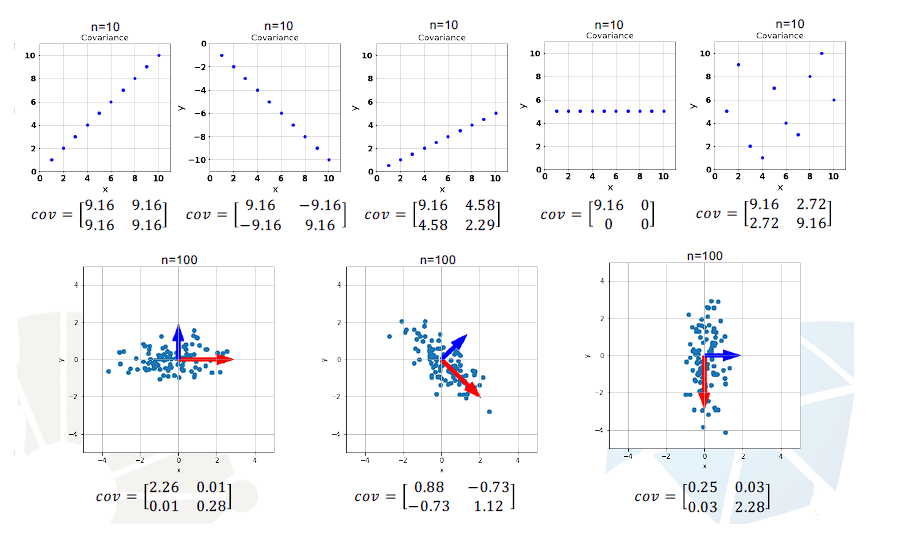


The `numpy` library provides a covariance matrix function `cov`:

In [10]:
# Compute covariance matrix
def covmatrix(X):
    CM = np.cov(X.T)  
    return CM

CM = covmatrix(U)

### Eigenvalues and Eigenvectors

For a given matrix A, an eigenpair ($\vec{e}$,$\lambda$) satisfy:


\begin{equation}
A\cdot \vec{e} = \lambda\cdot \vec{e}
\end{equation}

**Eigenvectors: $\vec{e}$**

- A $𝑛 \times 𝑛$ matrix that is diagonizable have $n$ eigenvectors

**Eigenvalues: $\lambda$**

- $\lambda$ represents the magnitude of the spread in a direction


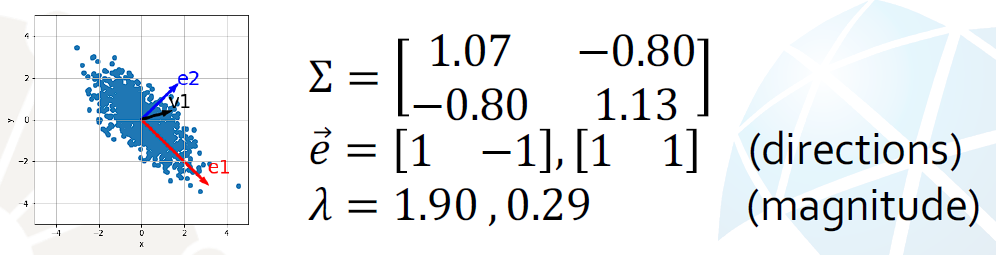

__Calculating Eigenvalues and Eigenvectors.__ The `numpy` library provides a _linear algebra_ package, that returns the Eigenvectors and Eigenvalues (not necessarily ordered).

e = [ $\lambda_1$, $\lambda_2$, $\lambda_3$ ... ]

E = [ [ $e1_1$, $e1_2$, $e1_3$, ... ]


In [11]:
#Compute Eigenvectors and Eigenvalues
def eigen(CM):    
    evalues, evectors = np.linalg.eig(CM)
    return evalues.real, evectors.real
e, E = eigen(CM)

### Components Selection

The **percentage of the total variance** of the data in a principal component *$𝑃𝐶_i$* can be expressed by:

\begin{equation}
PC_i = \frac{\lambda_i}{\sum_{p}^{i=1}\lambda_i}\times 100%
\end{equation}

__Components Analysis.__ Checking the percentage of _variance explained_ by each eigenvalue.

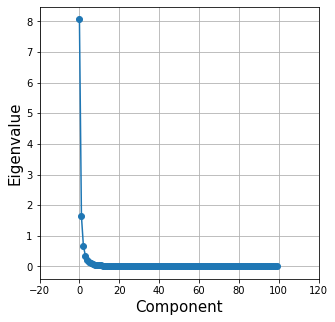

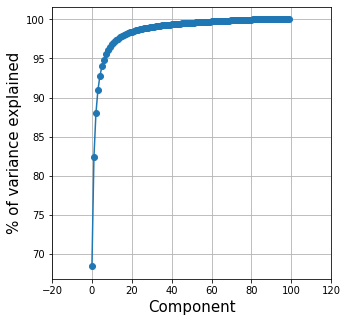

In [12]:
# Components analysis
def component_analysis(e, plot='none'):
    varexp = 100* e/e.sum()
    cumvarexp = np.cumsum(varexp)

    # Plotting Eigenvalues...
    if (plot=='eigen'):
        plt.figure(figsize = (5,5))
        plt.plot(e, '-o')
        plt.grid(True)
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('Eigenvalue', fontsize = 15)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    # Plotting Variance explained...
    if (plot=='varexp'):
        plt.figure(figsize = (5,5))
        plt.plot(cumvarexp, '-o')
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('% of variance explained', fontsize = 15)
        plt.grid(True)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    plt.show()

#Viewing.... plot=['eigen', 'varexp']
component_analysis(e, plot='eigen')  
component_analysis(e, plot='varexp')

__Selecting Eigenvectors.__ Let's show the eigenvectors corresponding to the best _k_ eigenvalues:

In [13]:
# Get the k most relevant eigenvalues
def components_select(e, E, k):
    best_index = (-e).argsort()[:k]
    pc = E[:, best_index]
    return pc

### Transforming data

__Transforming data to the new space.__ Now we need to transform the data to the new space with the selected components. At this moment we will transform the original data (U).

In [14]:
# Calculating the eigenmatrix
def transform(X, PC):    
    return np.dot(X, PC)

In [15]:
def inverse_transform(Xpc, PC):
    return np.dot(Xpc, PC.T)

In [16]:
def explained_variance_ratio(e, k):
    varexp = e/e.sum()
    cumvarexp = np.cumsum(varexp)    
    total_modal_energy = cumvarexp[k-1]        
    return total_modal_energy*100

### POD Projection

Function responsible for makes the projection of the **POD** with the **reduced space** that preserves the **greatest energy of the system**

In [17]:
def project(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f'total_modal_energy: {round(total_modal_energy, 2)}%')
    return transform(X, PC), PC, total_modal_energy

### Reconstructs the original space

Function that reconstructs the original space with the modes extracted in the POD projection through the product between the **projected U** and the **modes**

In [18]:
def reconstruct(X_projected, modes):
    return inverse_transform(X_projected, modes)

### Function to calculate the relative error

The relative error is calculate through of the $l^2-norm$ applied to the **original data U** and **reconstructed data U**

The $l^2-norm$ $\mathbf{x}$ is a **vector norm** defined for a **complex vector**

\begin{equation}
    \mathbf{x} = \begin{bmatrix}
    x_{1}\\ 
    x_{2}\\ 
    \vdots\\ 
    x_{n}
    \end{bmatrix}
\end{equation}

by 

\begin{equation}
    \left | \mathbf{x} \right | = \sqrt{\sum_{k=1}^{n} \left | x_{k} \right |^{2}}
\end{equation}

The **relative error** is given by:

\begin{equation}
    \frac{l^2(\Phi _{ori}) - l^2(\Phi _{rec})}{l^2(\Phi _{ori})}
\end{equation}

where, 

$\Phi _{ori}$ = original data U
$\Phi _{rec}$ = reconstructed data U



In [19]:
def POD_error(X_original, X_reconstructed):
    error = 100*np.linalg.norm(X_original - X_reconstructed, 2)
    error /= np.linalg.norm(X_original, 2)    
    print(f'The projection error for POD is {round(error, 2)}%')

### Creating a PCA_ED function

**Eigen-Decomposition (ED)**

- Matrix **decomposition: factorization** of a matrix into a product of matrices
- For square ($𝑛 \times 𝑛$) matrices:

\begin{equation}
A = U\cdot \Lambda \cdot U^{T}
\end{equation}

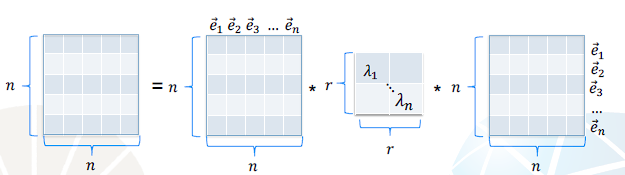

**Algorithm PCA flow using Eigen-Decomposition (ED):**

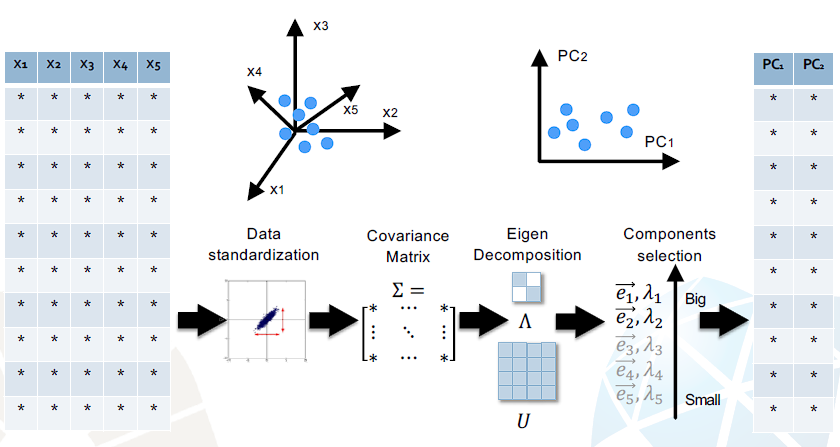



Creating our PCA function using Eigen-Decomposition (ED).

In [20]:
# Creating a PCA function based on EVD
def PCA_ED(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    Xpc = transform(X, PC)       
    Xpc_inv = inverse_transform(Xpc, PC)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f"Modal energy preserved: {round(total_modal_energy, 2)}%")
    component_analysis(e, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

## Compare Results

### Results for PCA ED

**Original Data**

In [21]:
k=40

Modal energy preserved: 99.33%


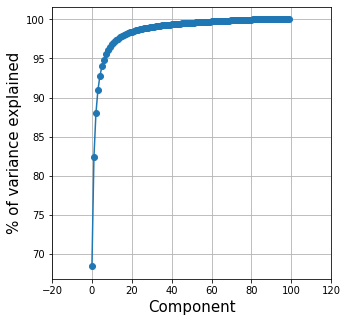

Mean error 0.03
The projection error for POD is 17.19%


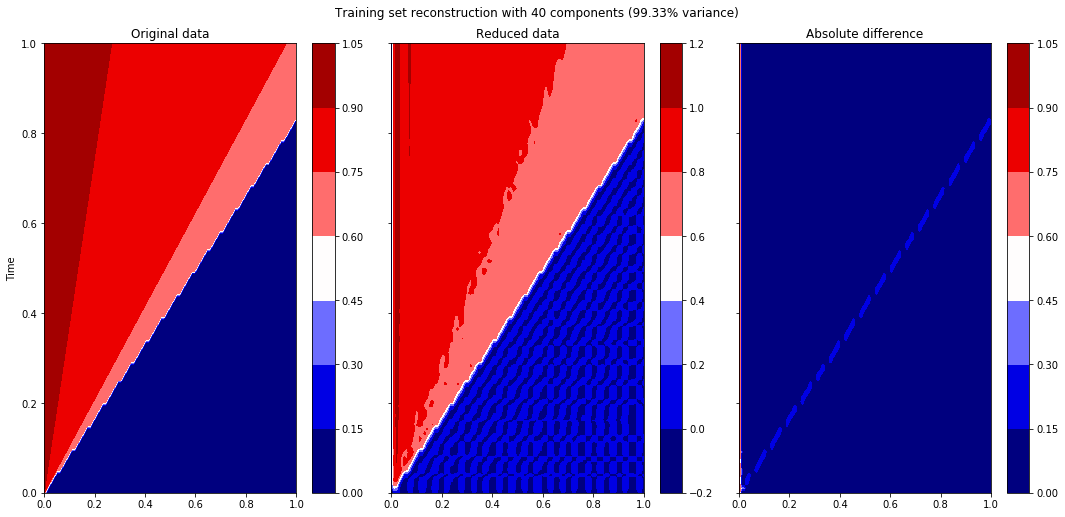

In [22]:
# Original Data
U_original_reconstructed, U_original_projected, PC, variance = PCA_ED(U, k)
plot_data_compare(X, T, U, U_original_reconstructed, k, variance)
POD_error(U, U_original_reconstructed)

## Trainning the Neural Network

### Obtaining the projected U and the modes

In this work, the 40 principal components ($PC_i$ or modes) will be used, which preserve approximately 99.3% of the system variance.

In [23]:
k = 40
u_projected, modes, variance = project(U, k)
print(u_projected.shape)

total_modal_energy: 99.33%
(100, 40)


### Separating training and test data

90% of the data will be separated for training and the remaining 10% for model validation

In [24]:
# The fraction of data used for training the model.
train_fraction = 0.9
test_fraction = 1 - train_fraction

In [25]:
# Choosing the number of training and testing samples
n_samples = U.shape[0]
train_samples = int(train_fraction * n_samples)
test_samples = n_samples - train_samples
print(train_samples)
print(test_samples)

90
10


In [26]:
u_projected_train = u_projected[1:train_samples+1,:]
x_train = X[1:train_samples+1,:]
t_train = T[1:train_samples+1,:]

u_projected_test = u_projected[train_samples+1:,:]
x_test = X[train_samples+1:,:]
t_test = T[train_samples+1:,:]

print(u_projected_train.shape)
print(u_projected_test.shape)

(90, 40)
(9, 40)


### Strategy to trainning de neural network

The strategy that is being used for training the neural network is:

- Apply the **POD projection** in the original dataset, and thus obtain the U function with the **reduced space** that **preserves the greatest energy** in the system.

- Once this is done, the data that will compose the neural network input are the $U_{i-1,j}$ (a previous timestep) and the data that will be used as target are $U_{i,j}$ (output of the NN), where this $U$ is the POD projection.

In [27]:
output_data_train = u_projected_train

input_data_train = np.zeros((output_data_train.shape[0], output_data_train.shape[1]))
input_data_train[0,:] = u_projected[0]
input_data_train[1:,:] = u_projected_train[:-1]

input_data_train.shape

(90, 40)

In [28]:
output_data_test = u_projected_test

input_data_test = np.zeros((output_data_test.shape[0], output_data_test.shape[1]))
input_data_test[0,:] = u_projected_train[-1]
input_data_test[1:,:] = u_projected_test[:-1]

input_data_test.shape

(9, 40)

In [29]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers
from keras.optimizers import SGD, Adam, Nadam, Adadelta
from sklearn.model_selection import train_test_split
import time

### Creating the Neural Network model

In [30]:
# Creating the NN
model = Sequential()
model.add(Dense(200, input_dim=input_data_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dense(output_data_train.shape[1], kernel_initializer='glorot_uniform', activation='linear')) # Out

# Defining the optimizer
optimizer = Adam()

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

### Fitting the model

In [31]:
history = model.fit(input_data_train, output_data_train, epochs=2000, batch_size=100, validation_data=(input_data_test, output_data_test), verbose=1)

Epoch 1/2000
1/1 [==============================] - 1s 863ms/step - loss: 1.1302 - mean_squared_error: 1.1302 - val_loss: 1.8154 - val_mean_squared_error: 1.8154
Epoch 2/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9767 - mean_squared_error: 0.9767 - val_loss: 1.5659 - val_mean_squared_error: 1.5659
Epoch 3/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.8447 - mean_squared_error: 0.8447 - val_loss: 1.3392 - val_mean_squared_error: 1.3392
Epoch 4/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.7277 - mean_squared_error: 0.7277 - val_loss: 1.1278 - val_mean_squared_error: 1.1278
Epoch 5/2000
1/1 [==============================] - 0s 59ms/step - loss: 0.6217 - mean_squared_error: 0.6217 - val_loss: 0.9375 - val_mean_squared_error: 0.9375
Epoch 6/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.5260 - mean_squared_error: 0.5260 - val_loss: 0.7690 - val_mean_squared_error: 0.7690
Epoch 7/2000
1/1 [===============

## Analysing the training e test curve with relation de epochs number

Looking at the graphs it was possible to notice that the training ans test data had good results with errors of the order of $2 \times 10^{-5}$. It was also noted that the model didn't suffer from overfitting, where the curves have walked together along the epochs.

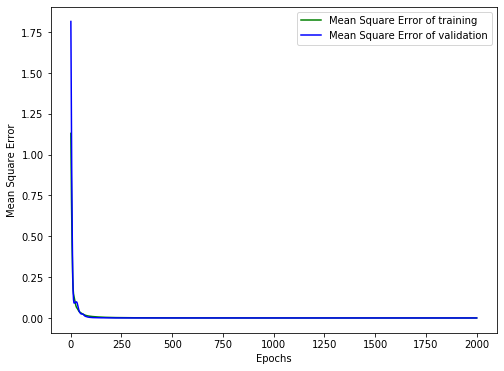

In [32]:
mean_squared_error_train = history.history['mean_squared_error']
mean_squared_error_test = history.history['val_mean_squared_error']

epochs = range(1, len(mean_squared_error_train) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, mean_squared_error_train, '-g', label='Mean Square Error of training')
plt.plot(epochs, mean_squared_error_test, '-b', label='Mean Square Error of validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

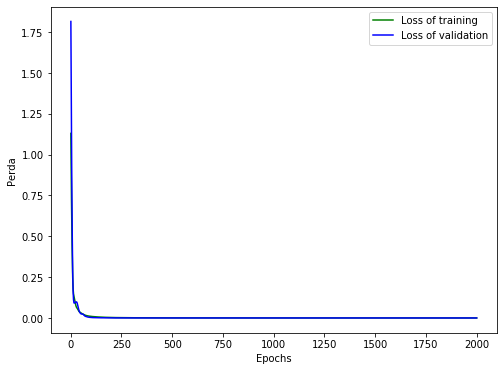

In [33]:
loss_train = history.history['loss']
loss_test = history.history['val_loss']

epochs = range(1, len(loss_train) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, loss_train, '-g', label='Loss of training ')
plt.plot(epochs, loss_test, '-b', label='Loss of validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perda')
plt.show()

In [34]:
model.save('model_bl.h5')

In [35]:
model = load_model('model_bl.h5')

## Final results

With the **trained model** the $U_{i,j}$ was predicted inputing the $U_{i-1,j}$ and these **reconstructed** with the **modes** of the **POD projection**.

### Prediction for training data

In [36]:
output = model.predict(input_data_train)
output.shape

(90, 40)

In [37]:
output_reconstructed = reconstruct(output, modes)
output_reconstructed.shape

(90, 100)

### Plotting the original data U normalized and the predicted and reconstructed data U

Mean error 0.03


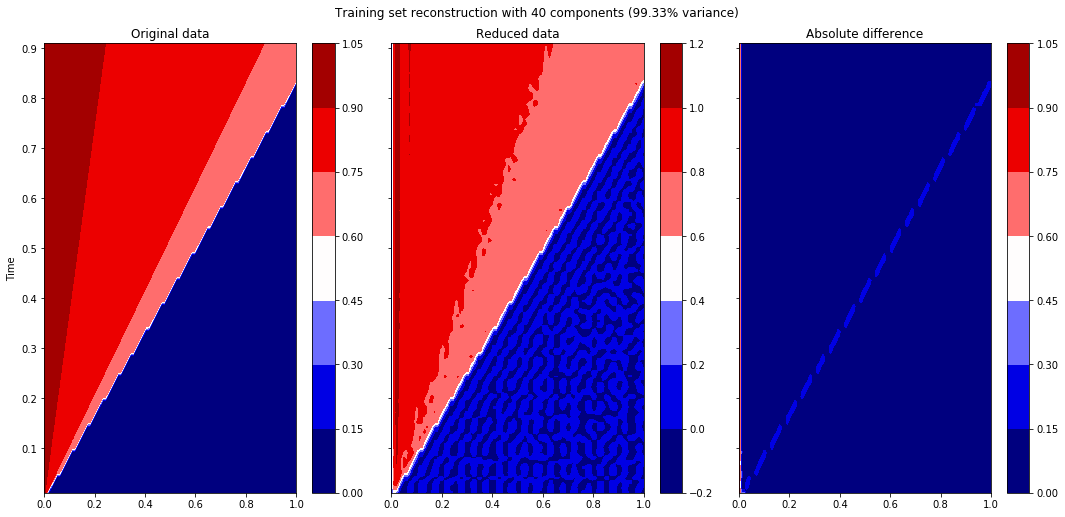

In [38]:
plot_data_compare(x_train, t_train, U[1:train_samples+1], output_reconstructed, k, variance)

### Plotting the original time series and the predicted time series

Comparing the orginal time series for the training data with the predicted time series

**timestep = 25**

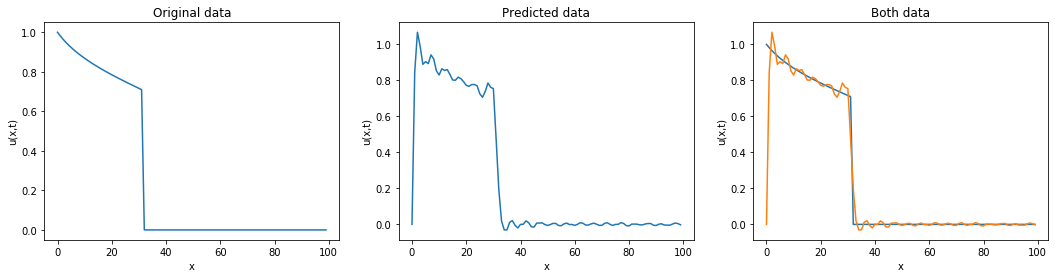

In [39]:
plot_time_serie(U[1:train_samples+1], output_reconstructed, time=25)

**timestep = 50**

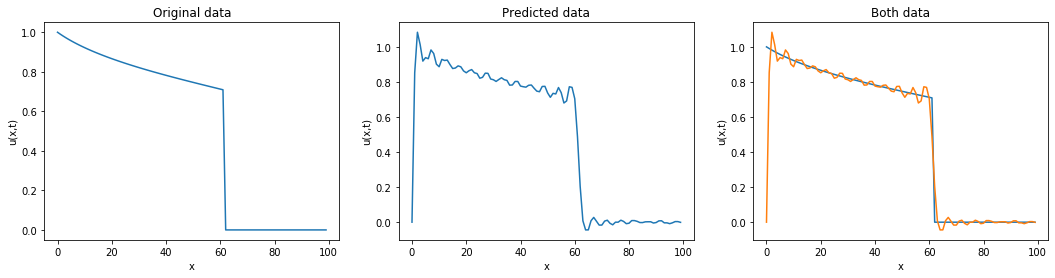

In [40]:
plot_time_serie(U[1:train_samples+1], output_reconstructed, time=50)

**timestep = 75**

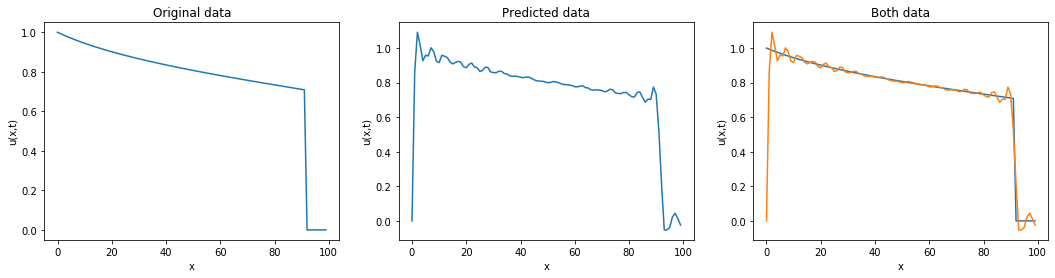

In [41]:
plot_time_serie(U[1:train_samples+1], output_reconstructed, time=75)

In [42]:
POD_error(U[1:train_samples+1], output_reconstructed)

The projection error for POD is 17.88%


### Prediction for validation (test) data

In [43]:
output = model.predict(input_data_test)
output.shape

(9, 40)

In [44]:
output_reconstructed = reconstruct(output, modes)
output_reconstructed.shape

(9, 100)

### Plotting the original data U normalized and the predicted and reconstructed data U

Mean error 0.0


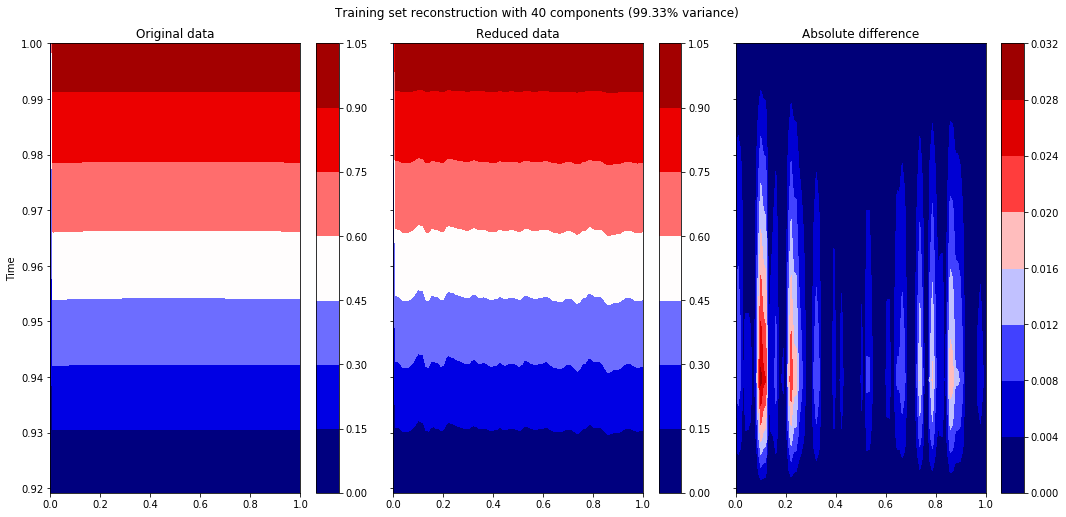

In [45]:
plot_data_compare(x_test, t_test, normalize(U[train_samples+1:]), normalize(output_reconstructed), k, variance)

### Plotting the original time series and the predicted time series

Comparing the orginal time series for the validation data with the predicted time series

**timestep = 1**

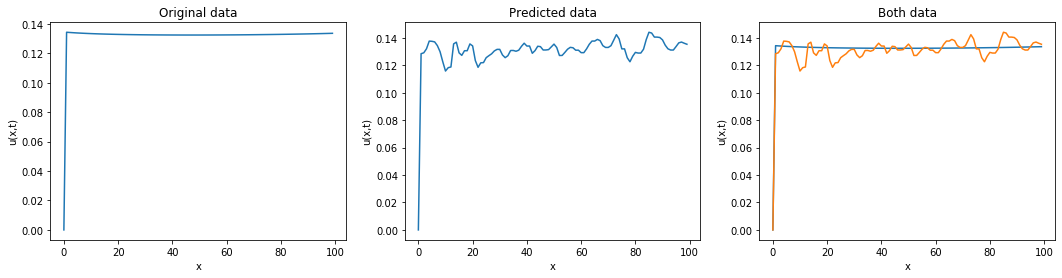

In [46]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=1)

**timestep = 6**

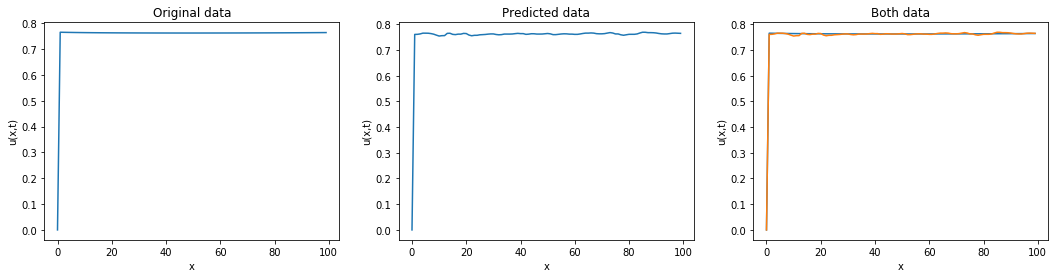

In [47]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=6)

**timestep = 8**

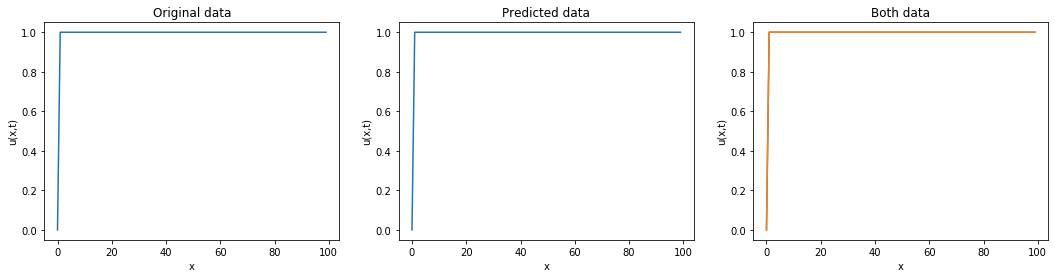

In [48]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=8)

In [49]:
POD_error(normalize(U[train_samples+1:]), normalize(output_reconstructed))

The projection error for POD is 0.85%


In [54]:
u_projected_, modes_, variance_ = project(U, 40)
u_projected_.shape

output_ = model.predict(u_projected_[:-1,:])
output_.shape

total_modal_energy: 99.33%


(99, 40)

In [55]:
output_reconstructed_ = reconstruct(output_, modes)
output_reconstructed_.shape

(99, 100)

In [58]:
x_train = X[1:,:]
t_train = T[1:,:]
t_train.shape

(99, 100)

In [59]:
U[:-1,:].shape

(99, 100)

Mean error 0.04


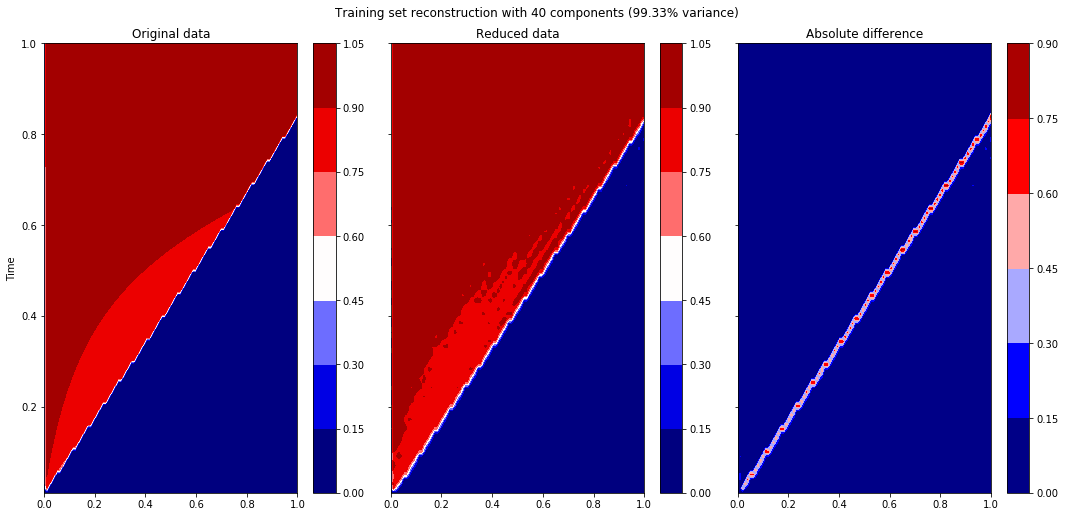

In [61]:
plot_data_compare(x_train, t_train, normalize(U[:-1,:]), normalize(output_reconstructed_), k, variance)